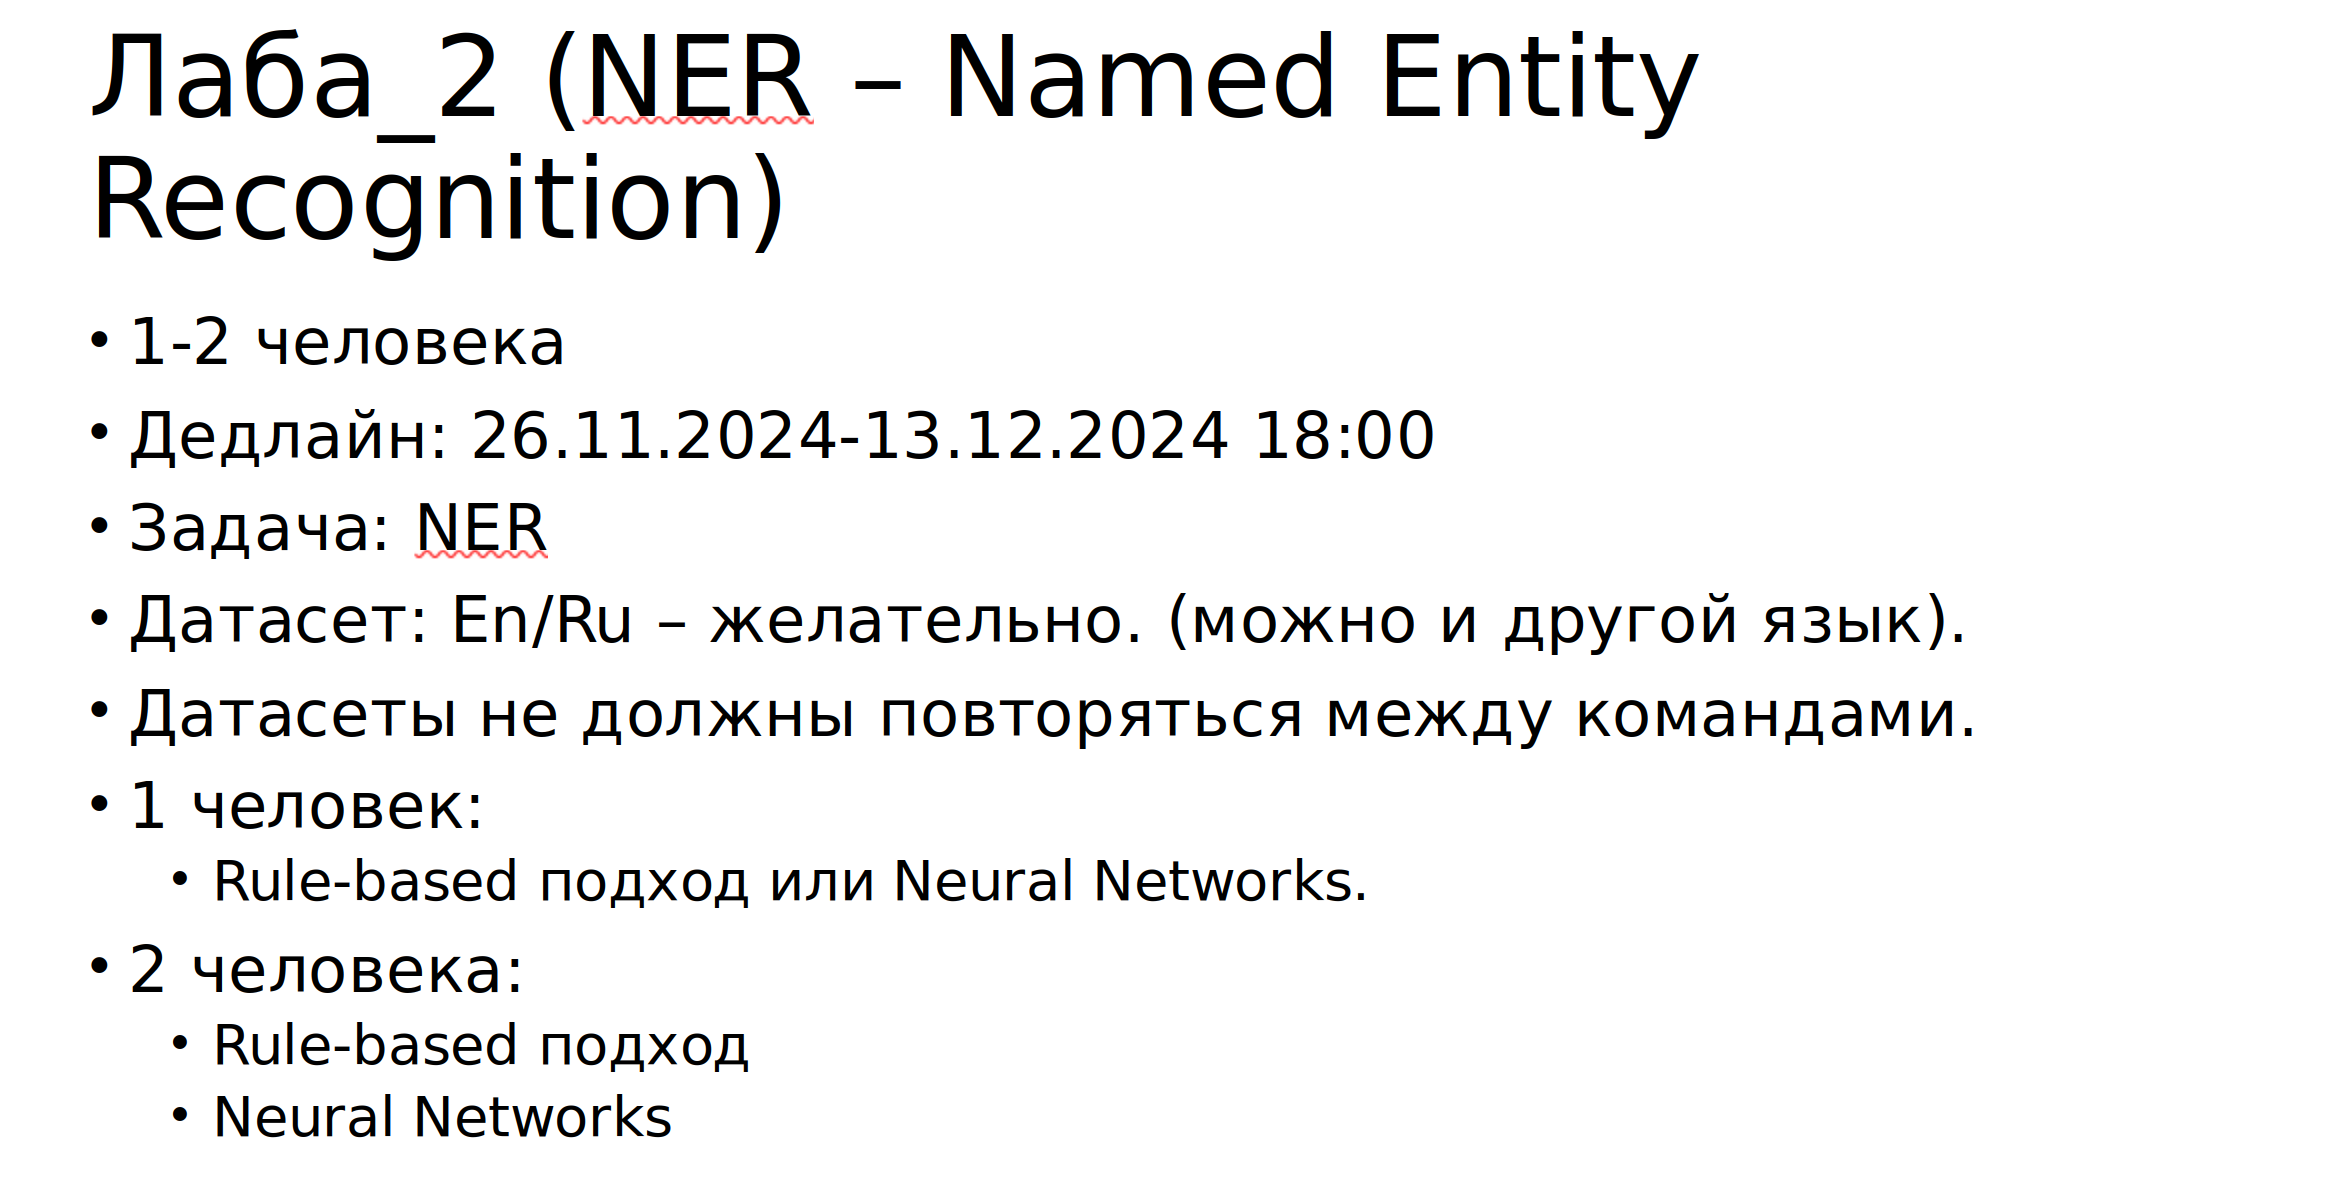

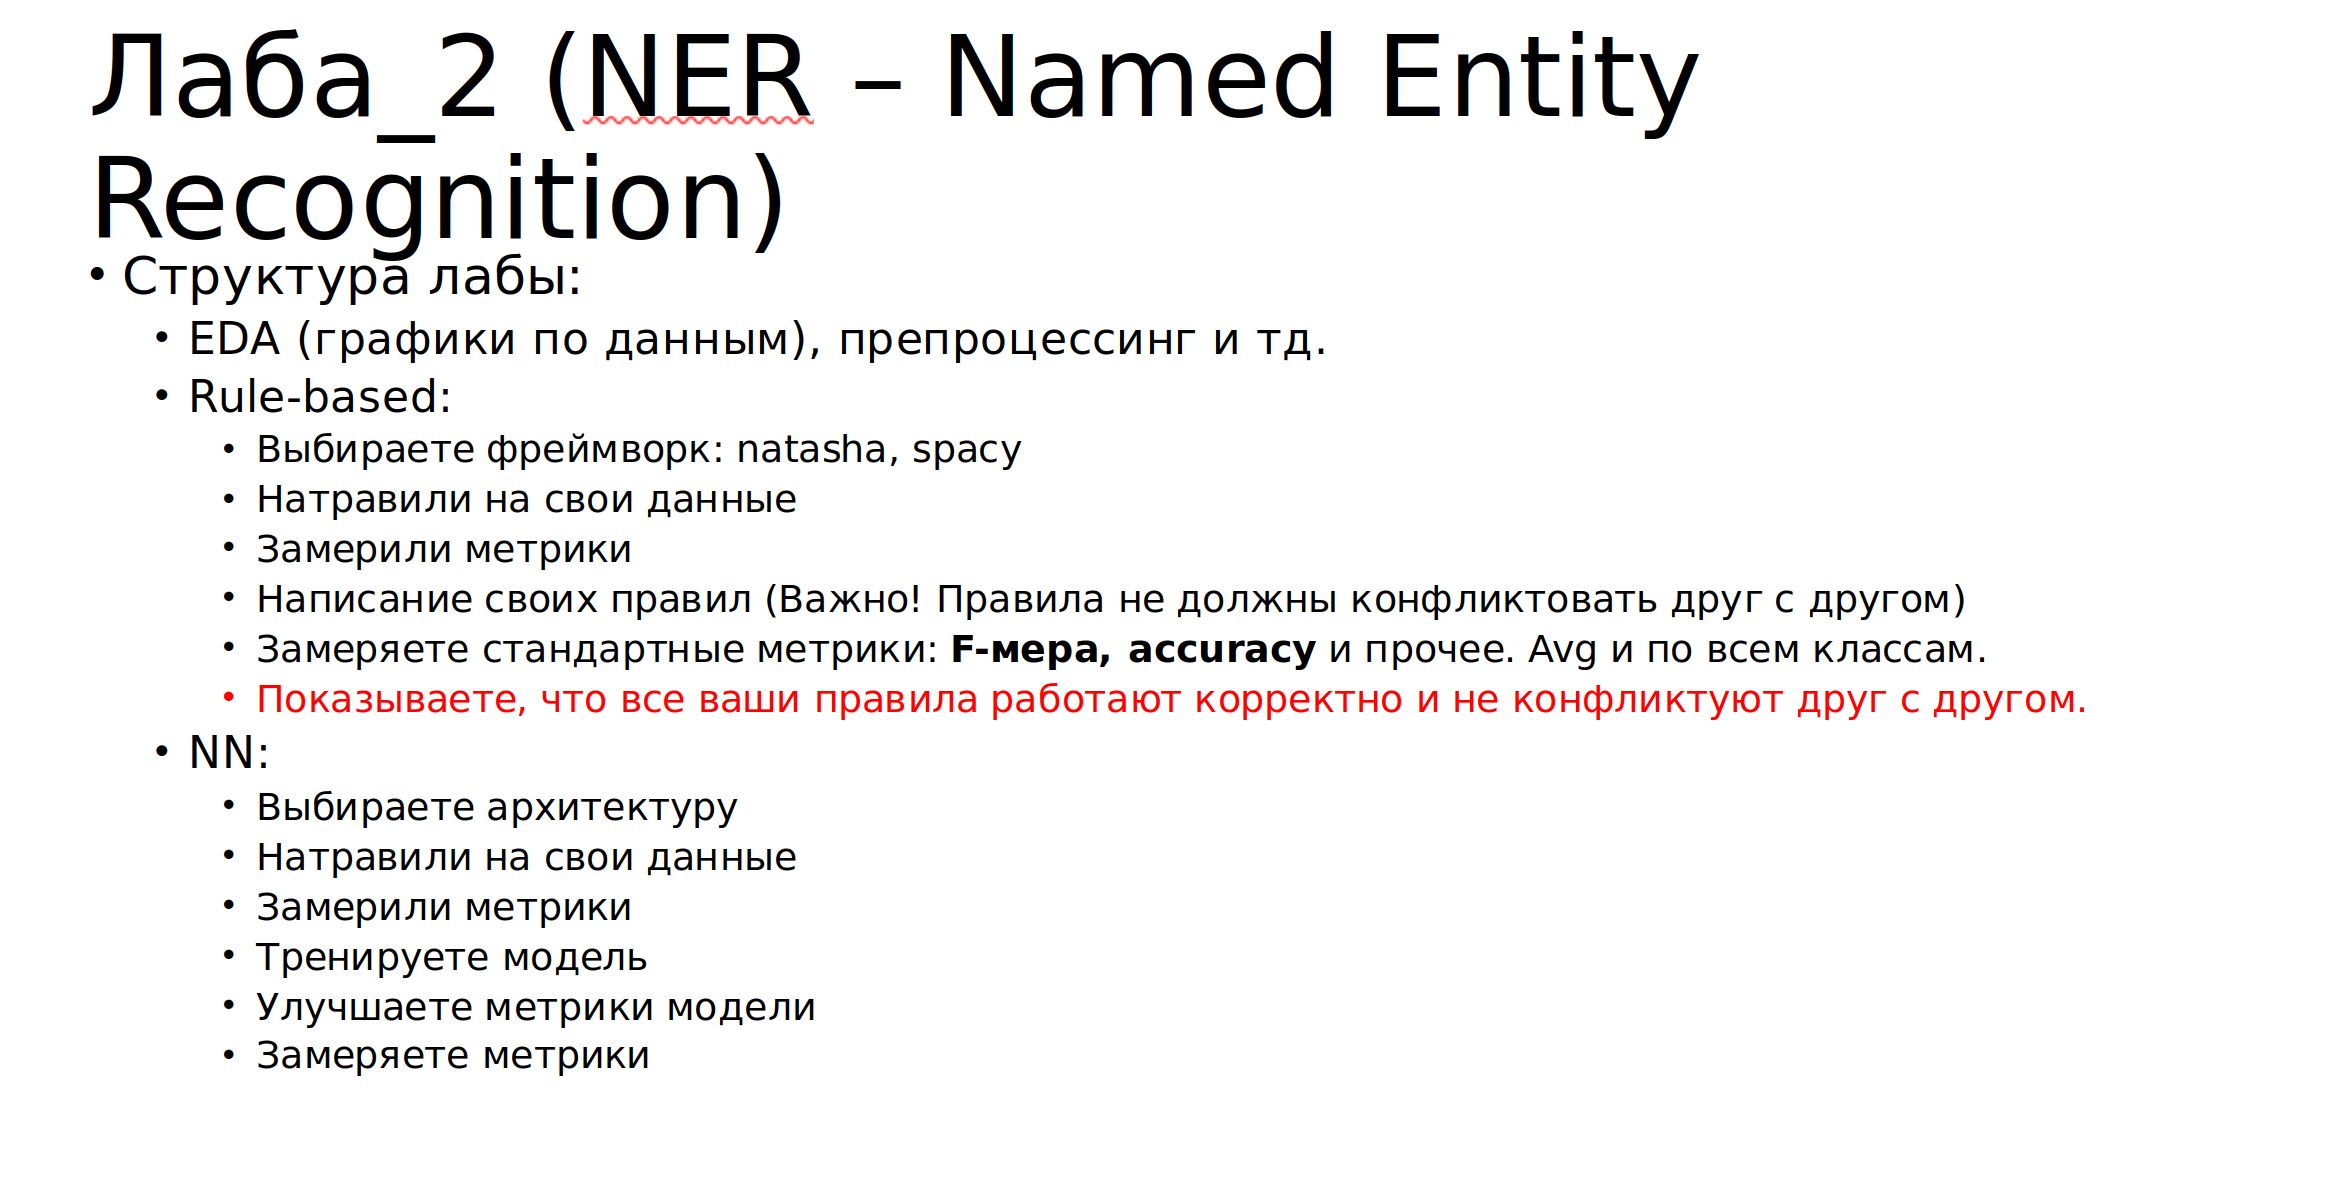

## Данные

[Ссылка на датасет](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/data)

Выбранный датасет содержит около 140000 предложений, взятых из статей англоязычной википедии.

In [5]:
import pandas as pd
import numpy as np

file = 'wikiner.txt'
with open(file, 'r') as f:
    file = f.readlines()

data = []
for line in file:
    try:
        ind, word, label = line.split()
    except:
        continue
    if ind == '0':
        data.append(data_dict)
        data_dict = {'tokens': [word], 'labels': [label]}
    else:
        data_dict['tokens'].append(word)
        data_dict['labels'].append(label)


data = pd.DataFrame(data)
data.head()

,tokens,labels
0,"[The, ITU, Radiocommunication, Sector, (, ITU-...","[O, B-ORG, I-ORG, I-ORG, O, B-ORG, O, O, O, O,..."
1,"[The, Oxford, Companion, to, Philosophy, says,...","[B-MISC, I-MISC, I-MISC, I-MISC, I-MISC, O, O,..."
2,"[In, the, end, ,, for, anarchist, historian, D...","[O, O, O, O, O, O, O, B-PER, I-PER, O, O, O, O..."
3,"[From, this, climate, William, Godwin, develop...","[O, O, O, B-PER, I-PER, O, O, O, O, O, O, O, O..."
4,"[Godwin, was, ,, according, to, Peter, Kropotk...","[B-PER, O, O, O, O, B-PER, I-PER, O, O, O, O, ..."


In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, random_state=42)

train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)
print(f'Train size: {train_data.shape[0]}')
print(f'Test size: {test_data.shape[0]}')

train_data.to_csv('./data/train.csv')
test_data.to_csv('./data/test.csv')

Train size: 108256
Test size: 36086


В данных представлена разметка. Каждому токену присвоен лейбл: О если токен не является частью именованной сущности, В если с этого токена начинается подпоследовательность именованной сущности, I - если токен принадлежит подпоследовательности именованной сущности.

Дополнительно лейблы I и B классифицированы на следующие классы:

* PER - Человек
* ORG - Организация
* LOC - Место
* MISC - именованная сущность, не пренадлежащая какой-либо из вышеописанных категорий (событие, произведение искусства и т.д.)


Посмотрим на разметку глазами:

In [10]:
import random

num_examples = 5
for document in range(num_examples):
  # beginning = random.randint(0, len(train_data.tokens[document]) - 16)
  beginning = 0
  ending = beginning + 20

  print(f'Document {document}, tokens from {beginning} to {ending}:')
  print(
      pd.DataFrame(
          {
              'tokens:': train_data.tokens[document][beginning:ending],
              'labels:': train_data.labels[document][beginning:ending]
          }
      )
      .transpose()
      .to_string(index=True, header=False),
      '\n'
  )


Document 0, tokens from 0 to 20:
tokens:  Julia  Agrippina  ,  most  commonly  referred  to  as  Agrippina  Minor  or  Agrippina    the  Younger  or  Agrippinilla  (  Little  Agrippina  )
labels:  B-PER      I-PER  O     O         O         O   O   O      B-PER  I-PER   O      B-PER  I-PER    I-PER   O         B-PER  O       O      B-PER  O 

Document 1, tokens from 0 to 20:
tokens:  The  company  also  noted  that  several  facts  classified  as  errors  by  Nature  were  minor  spelling  variations  ,  and  that  several
labels:    O        O     O      O     O        O      O           O   O       O   O  B-MISC     O      O         O           O  O    O     O        O 

Document 2, tokens from 0 to 20:
tokens:  In  2007  ,  State     of  Israel  granted  7,176  permits  and  denied  1,627  .
labels:   O     O  O  B-LOC  I-LOC   I-LOC        O      O        O    O       O      O  O 

Document 3, tokens from 0 to 20:
tokens:  The  National  Dairy  Research  Institute  at  Karnal  ,  a

Посмотрим на примеры категорий:

In [11]:
labels = set([
    label.split('-')[-1]
    for annot in train_data.labels
    for label in annot
]) - {'O'}


def get_examples(label: str, num_examples: int):
  examples = []
  for document in range(0, train_data.shape[0]):
    if len(examples) >= num_examples:
      return examples
    try:
      beginning = train_data.labels[document].index(f'B-{label}')
    except ValueError:
      continue

    example = train_data.tokens[document][beginning].strip()
    for token_id in range(beginning + 1, len(train_data.tokens[document]) - 1):
      if train_data.labels[document][token_id] == f'I-{label}':
        example += ' ' + train_data.tokens[document][token_id].strip()
    examples.append(example)

  print(f'WARNING: could not find {num_examples} examples for label {label}, found {len(examples)} examples')
  return examples


label_examples = {}
for label in labels:
  label_examples[label] = get_examples(label=label, num_examples=10)

In [12]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in label_examples.items()])).T

,0,1,2,3,4,5,6,7,8,9
ORG,National Dairy Research Institute,Liberal Party,Wales,New Statesman,Colt,NATO military,Brown,Hunter,New World,ITV
PER,Julia Agrippina Minor the Younger Augusta Agri...,Jo Grimond,Connolly,Augustine,Francis Wayland,Alexander,Bede,Paul VI,John Russell,Jesus Christ
MISC,Nature,Conservative,World War II,New Zealand team,Burmese Days,Notes on the Synthesis of Form,CH-46,Godzilla 1985,Celebrity Fit Club,Centennial Olympic Park bombing
LOC,Roman,State of Israel,Karnal Institute for Research on Buffaloes,Paris,Rome,Lake District,Elstree,Ballarat,Iraq,New York Jersey


## EDA

### Какова длина предложений?

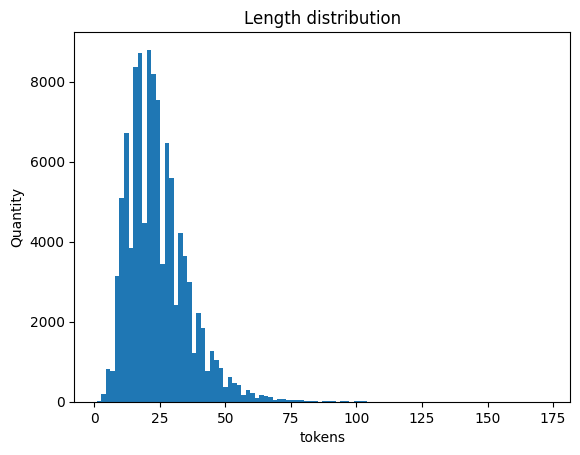

In [16]:
train_data.tokens.apply(len).plot.hist(title='Length distribution', xlabel='tokens', ylabel='Quantity', bins=100);

### Как часто встречаются NE?

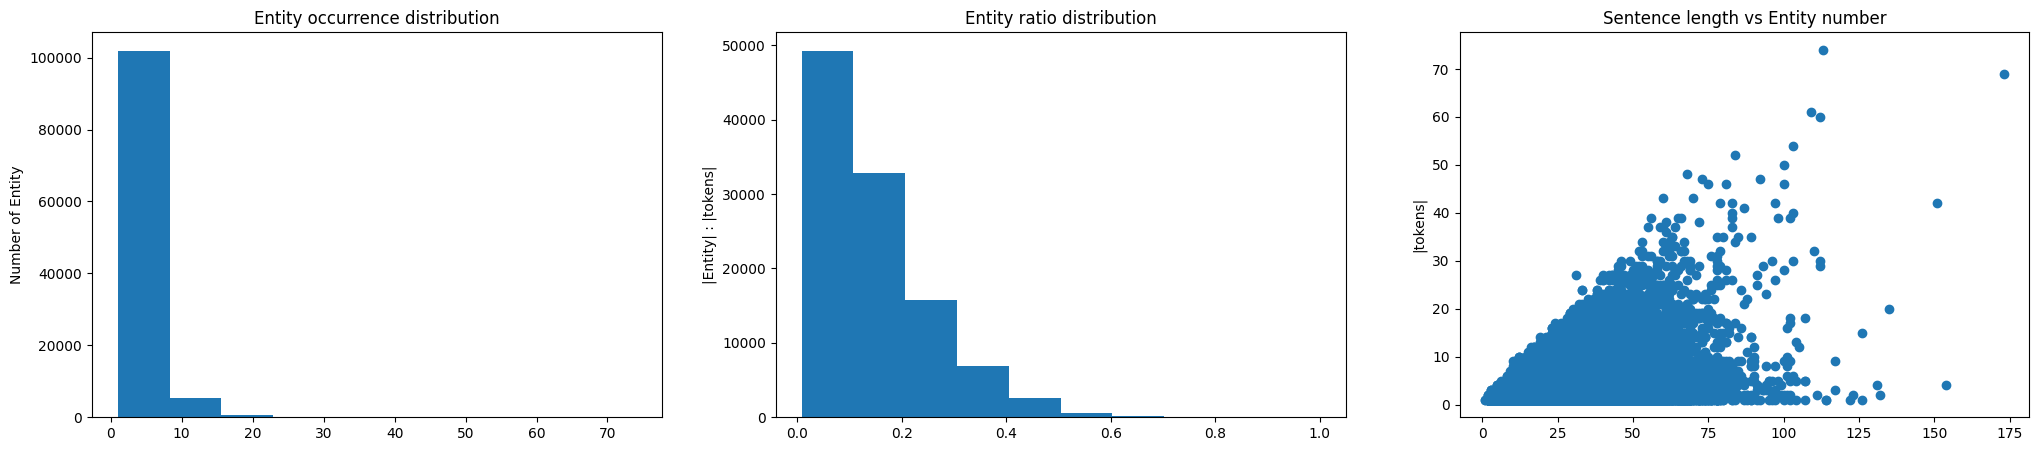

In [14]:
from matplotlib import pyplot as plt

non_pii_count = train_data.labels.apply(lambda x: x.count('O'))
pii_count = train_data.labels.apply(len) - non_pii_count
pii_ratio = pii_count / train_data.labels.apply(len)


fig, axes = plt.subplots(1, 3, figsize=(25, 5))
axes[0].hist(pii_count)
axes[0].set_title('Entity occurrence distribution')
axes[0].set_ylabel('Number of Entity')

axes[1].hist(pii_ratio)
axes[1].set_title('Entity ratio distribution')
axes[1].set_ylabel('|Entity| : |tokens|')

axes[2].scatter(train_data.labels.apply(len), pii_count)
axes[2].set_title('Sentence length vs Entity number')
axes[2].set_ylabel('|Entity|')
axes[2].set_ylabel('|tokens|')

plt.show()

In [18]:
print('Среднее количество сущностей в тексте:', pii_count.mean(), 'Максимальное количество: ', pii_count.max())

Среднее количество сущностей в тексте: 3.3672406148389005 Максимальное количество:  74


In [22]:
print('Коэффициент корреляции длины и кол-ва NE:', np.corrcoef(pii_count, train_data.labels.apply(len))[0, 1])

Коэффициент корреляции длины и кол-ва NE: 0.38374735633987433


В целом, интересующие категории встречаются не очень часто: в среднем меньше пяти раз, при этом максимальное наблюдаемое количество -- 74. Они как правило составляют менее 10 процентов от общего текста.

Присутствует небольшая положительная корреляция между количеством сущностей и длиной предложения, что вполне логично.

### Распределение категорий

In [25]:
labels = ['ORG', 'PER', 'LOC', 'MISC']

def plot_categ_distribution(data):
    labels_dict = dict(zip(labels, [0] * 4))
    def count_labels(tokens):
        for token in tokens:
            if token.startswith('B'):
                labels_dict[token.split('-')[-1]] += 1
    data['labels'].apply(count_labels)
    plt.bar(labels_dict.keys(), labels_dict.values())

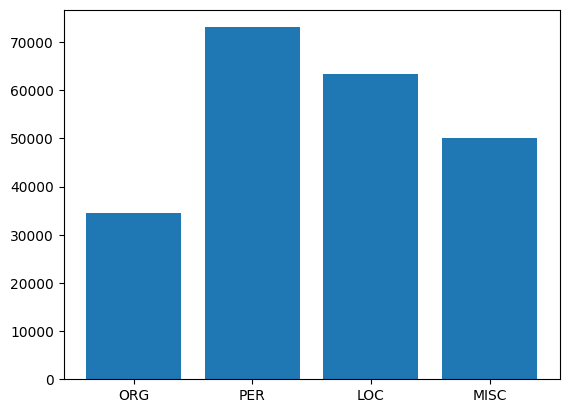

In [26]:
plot_categ_distribution(train_data)

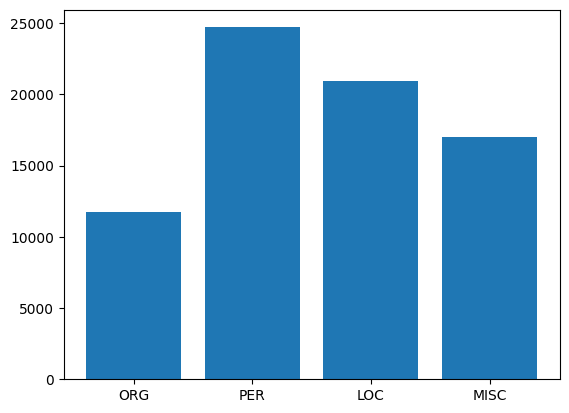

In [27]:
plot_categ_distribution(test_data)

Как можно видеть, меньше всего в датасете представлено организаций, больше всего - персон. Распределение в тренировочной и тестовой выборке  совпадают.  
Остальные именованные сущности (MISC) тоже представлены меньше, по сравнению с остальными. Если учесть что они сами являются примерами из различных категорий, с их идентифицированием могут возникнуть проблемы, так как они могут быть слаюо представлены.

## Spacy и rule-based подход

In [28]:
import spacy
from spacy.pipeline import EntityRuler

In [29]:
nlp = spacy.load("en_core_web_sm")

In [39]:
ner.set_annotations([doc2], score)
doc2

Apple is opening its first big office in San Fran.

In [50]:
from sklearn.metrics import classification_report

label_2_id = {'O' :0, 'B-ORG': 1, 'I-ORG': 2, 'B-PER': 3, 'I-PER': 4,
              'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


def compute_spacy_metrics(data, nlp):
    ner = nlp.get_pipe('ner')
    for row in data:
        processed_row = nlp(row['tokens'])
        entities = ['-'.join([e.ent_iob_, e.ent_type_]) if e.ent_iob_ != 'O' else 'O' for e in doc]
        pred_inds = [label_2_id[ent] for ent in entities]
        real_inds = [label_2_id[ent] for ent in row['labels']]
        equals = (pred_inds == real_inds)